In [1]:
import scanpy as sc
from pathlib import Path
from dask import array as da
from tqdm.dask import TqdmCallback

from utils.cellxgene import get_cxg_url
from utils.io import read_anndata

/Users/michaela.mueller/miniforge3/envs/scanpy_student/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'Hrovatin2023'
file_path = f'data/{dataset_name}.h5ad'

# Get data

In [3]:
url = get_cxg_url(
    collection_id="296237e2-393d-4e31-b590-b03f74ac5070",
    dataset_id="49e4ffcc-5444-406d-bdee-577127404ba8"
)

Get URL for CxG collection ID "296237e2-393d-4e31-b590-b03f74ac5070" and dataset ID "49e4ffcc-5444-406d-bdee-577127404ba8"
URL: https://datasets.cellxgene.cziscience.com/20624c4a-8eb9-4468-97d2-456df84b9a9a.h5ad


In [4]:
# download only if the file does not exist
if not Path(file_path).exists():
    !curl {url} > {file_path}

In [5]:
adata = read_anndata(
    file_path,
    X='X',
    obs='obs',
    var='var',
    obsm='obsm',
    obsp='obsp',
    dask=True,
    backed=True,
)
adata

dask: True, backed: True
chunks: ('auto', -1)
Read slot "X", store as "X"...
Read X as backed sparse dask array...
Read slot "obs", store as "obs"...
Read slot "var", store as "var"...
Read slot "obsm", store as "obsm"...
Read slot "obsp", store as "obsp"...


AnnData object with n_obs × n_vars = 301796 × 31202
    obs: 'batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample', 'cell_subtype_immune_reannotatedIntegrated', 'cell_subtype_endothelial_reannotatedIntegrated', 'emptyDrops_LogProb_scaled', 'cell_subtype_beta_coarse_reannotatedIntegrated', 'cell_subtype_beta_fine_reannotatedIntegrated', 'GP_1', 'GP_2', 'GP_3', 'GP_4', 'GP_5', 'GP_6', 'GP_7', 'GP_8', 'GP_9', 'GP_10', 'GP_11', 'GP_12', 'GP_13', 'GP_14', 'GP_15', 'GP_16', 'GP_17', 'GP_18', 'GP_19', 'GP_20', 'GP_21', 'GP_22', 'GP_23', 'GP_24', 'GP_25', 'GP_26', 'GP_27', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'diabetes_model', 'chemical_stress', 'GEO

## Visualise data

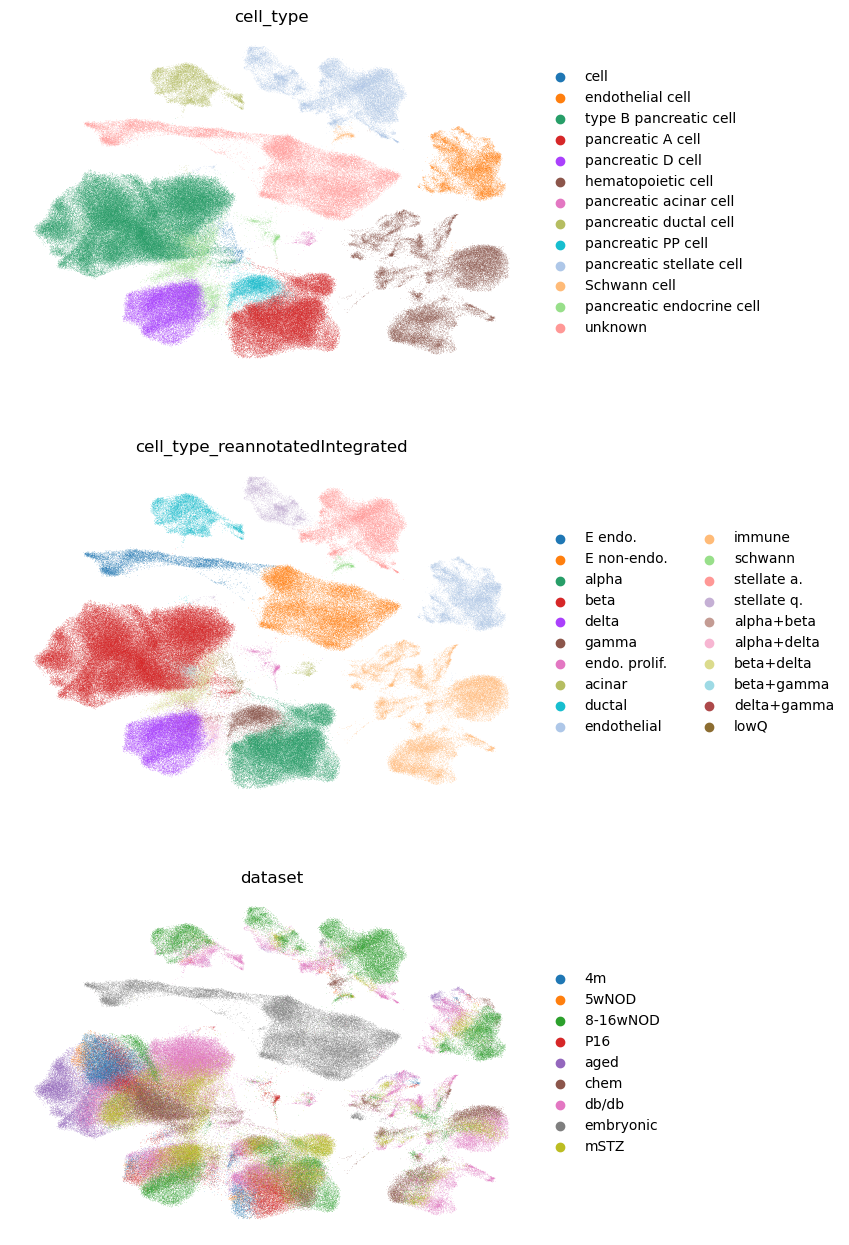

In [6]:
sc.pl.embedding(
    adata,
    'X_integrated_umap',
    color=['cell_type', 'cell_type_reannotatedIntegrated', 'dataset'],
    ncols=1,
    frameon=False,
)

# Preprocess data

In [7]:
adata.layers['counts'] = adata.X.copy()

In [8]:
if isinstance(adata.X, da.Array):
    with TqdmCallback(leave=False):
        adata.X = adata.X.compute()

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='dataset')

CPU times: user 15.1 s, sys: 28.4 s, total: 43.5 s
Wall time: 1min


In [12]:
%%time
sc.pp.pca(adata, n_comps=50, mask_var='highly_variable')

CPU times: user 21.3 s, sys: 6.59 s, total: 27.9 s
Wall time: 33.9 s


In [13]:
%%time
sc.pp.neighbors(adata, use_rep='X_pca')

CPU times: user 54.8 s, sys: 2.85 s, total: 57.6 s
Wall time: 58.8 s


In [14]:
%%time
sc.tl.umap(adata)

CPU times: user 5min 59s, sys: 10.6 s, total: 6min 10s
Wall time: 3min 51s


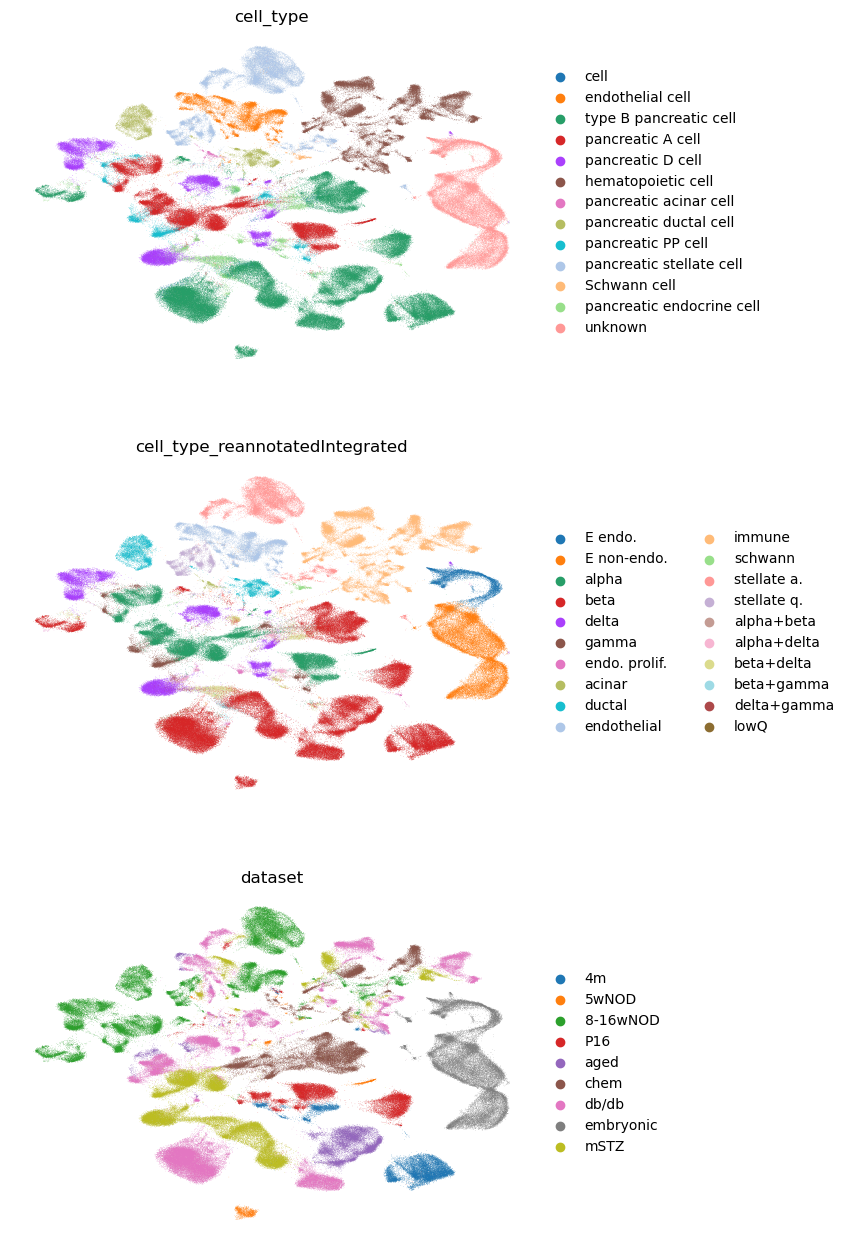

In [15]:
sc.pl.umap(
    adata,
    color=[
        'cell_type',
        'cell_type_reannotatedIntegrated',
        'dataset',
    ],
    ncols=1,
    frameon=False,
)

In [16]:
adata.write_zarr(f'data/{dataset_name}_preprocessed.zarr')